In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the data directory
datadir = '/content/drive/MyDrive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/'
Categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

# Load and preprocess the data
flat_data_arr = []
target_arr = []

for i in Categories:
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    for img in os.listdir(path):
        img_array = imread(os.path.join(path, img))
        img_resized = resize(img_array, (150, 150, 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category: {i} successfully')


flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

loading... category : Bengin cases
loaded category: Bengin cases successfully
loading... category : Malignant cases
loaded category: Malignant cases successfully
loading... category : Normal cases
loaded category: Normal cases successfully


In [3]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(flat_data, target, test_size=0.2, random_state=42)

# Reshape the data for CNN input
x_train = x_train.reshape(-1, 150, 150, 3)
x_test = x_test.reshape(-1, 150, 150, 3)

# Convert target labels to categorical
y_train = to_categorical(y_train, num_classes=len(Categories))
y_test = to_categorical(y_test, num_classes=len(Categories))


In [4]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(len(Categories), activation='softmax')
])

learning_rate = 0.00001  # Set your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback
checkpoint_path = '/content/drive/MyDrive/ct_scan_CNN.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor='val_accuracy',
                                                mode='max',
                                                verbose=1)


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [6]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=32, callbacks=[checkpoint])



Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.5507
Epoch 1: val_accuracy improved from -inf to 0.62727, saving model to /content/drive/MyDrive/ct_scan_CNN.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 21s 282ms/step - loss: 0.9139 - accuracy: 0.5507 - val_loss: 0.8935 - val_accuracy: 0.6273
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.8206 - accuracy: 0.6586
Epoch 2: val_accuracy improved from 0.62727 to 0.64545, saving model to /content/drive/MyDrive/ct_scan_CNN.h5
28/28 [==============================] - 6s 218ms/step - loss: 0.8207 - accuracy: 0.6579 - val_loss: 0.8348 - val_accuracy: 0.6455
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.6750
Epoch 3: val_accuracy improved from 0.64545 to 0.67273, saving model to /content/drive/MyDrive/ct_scan_CNN.h5
28/28 [==============================] - 5s 175ms/step - loss: 0.7634 - accuracy: 0.6750 - val_loss: 0.7695 - val_accuracy: 0.6727
Epoch 4/50
27/28 [===========================>..] - ETA: 0s - loss: 0.7065 - accuracy: 0.7222
Epoch 4: val_accuracy improved from 0.67273 to 0.71364, saving model to /content/drive/MyDrive/ct_scan_C

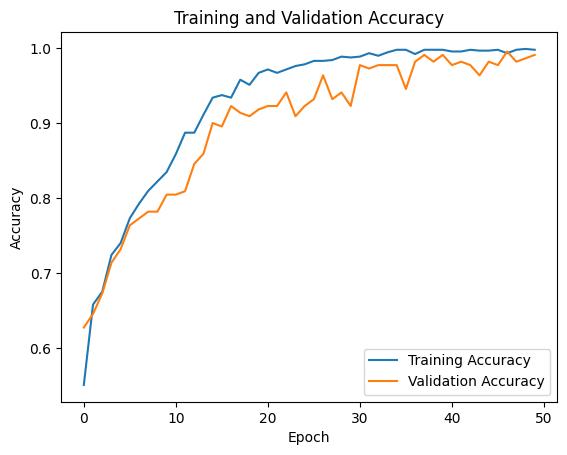

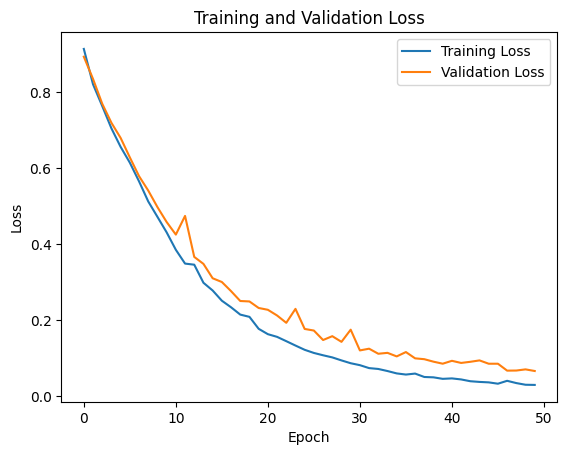

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [8]:
# Predict on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

7/7 [==============================] - 0s 21ms/step


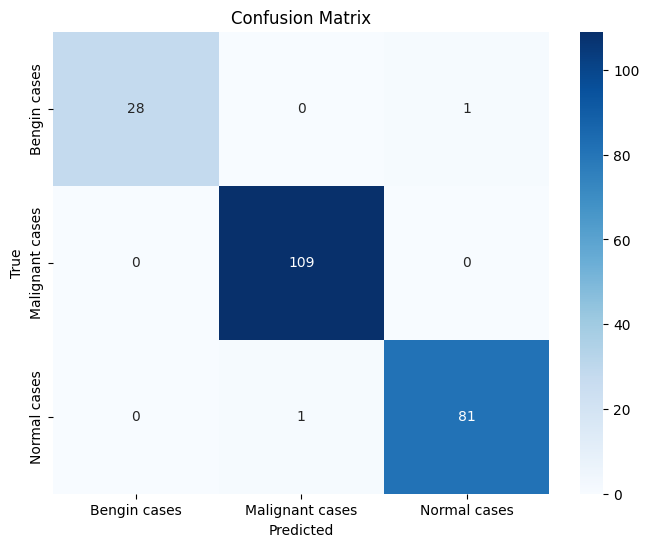

In [9]:

# Plot confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [10]:
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=Categories))



                 precision    recall  f1-score   support

   Bengin cases       1.00      0.97      0.98        29
Malignant cases       0.99      1.00      1.00       109
   Normal cases       0.99      0.99      0.99        82

       accuracy                           0.99       220
      macro avg       0.99      0.98      0.99       220
   weighted avg       0.99      0.99      0.99       220



In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

7/7 [==============================] - 0s 15ms/step - loss: 0.0654 - accuracy: 0.9909
Test accuracy: 0.9909090995788574
